In this section, you’ll build a network to classify Reuters newswires into 46 mutually
exclusive topics.

This problem is an instance of multiclass classification; and because each data point should be classified into *only one category*, the problem is more specifically an instance of *single label*, multiclass classification.

If each data point could belong to multiple categories (in this case, topics), you’d be facing a *multilabel, multiclass classification* problem.

### The Reuters dataset

A set of short newswires and their topics, published by Reuters in 1986. 

It’s a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic
has at least 10 examples in the training set.

#### Loading the Reuters dataset

In [ ]:
# Force Keras to use CPU
# Windows
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Linux
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000
)

Using TensorFlow backend.


The argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.
You have 8,982 training examples and 2,246 test examples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

Each example is a list of integers (word indices):

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

### Decoding newswires back to text

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])

Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”

The label associated with an example is an integer between 0 and 45—a topic index:

In [7]:
train_labels[10]

3

### Preparing the data

You can vectorize the data with the exact same code as in the previous example.

In [8]:
import numpy as np


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

In [9]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the *labels*, there are two possibilities: 

* You can cast the label list as an integer tensor

* You can use one-hot encoding. 

One-hot encoding is a widely used format for categorical data, also called categorical encoding. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index.

In [10]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.0
    return results

In [11]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you’ve already seen in action
in the MNIST example:

In [12]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### Building your network

There is a new constraint here: the number of output classes has gone from 2 to 46. The dimensionality of the output space is much larger.

In a stack of Dense layers like that you’ve been using, each layer can only access information present in the output of the previous layer. 

If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. 

In the previous example, you used 16-dimensional intermediate layers, but *a 16-dimensional space may be too limited to learn to separate 46 different classes*: such small layers may act as information bottlenecks, permanently dropping relevant information. For this reason you’ll use larger layers. Let’s go with 64 units.

### Model definition

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

* You end the network with a Dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.

* The last layer uses a softmax activation. It means the network will output a probability distribution over the 46 different output classes—for every input sample, the network will produce a 46- dimensional output vector, where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.

The best loss function to use in this case is *categorical_crossentropy*. 
It measures the distance between two probability distributions: here, between the probability distribution output by the network and the true distribution of the labels.

### Compiling the model

In [14]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

### Validating your approach

Let’s set apart 1,000 samples in the training data to use as a validation set.

In [15]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

#### Training the model

Now, let’s train the network for 20 epochs.

In [16]:
# if 'session' in locals() and session is not None:
#     print('Close interactive session')
#     session.close()

In [17]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 270us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 181us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 183us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 167us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 170us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 171us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 171us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020


### Plotting the training and validation loss

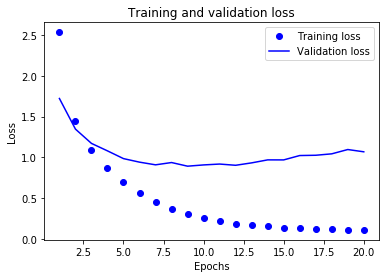

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Plotting the training and validation accuracy

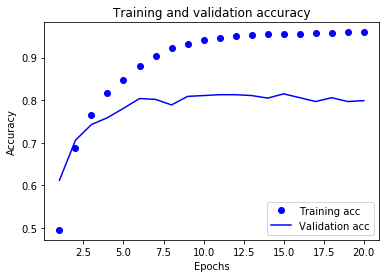

In [19]:
plt.clf()
acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Early Stopping

The network begins to overfit after nine epochs. Let’s train a new network from scratch for nine epochs and then evaluate it on the test set.

#### Retraining a model from scratch

In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val, y_val),
)

results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 196us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 166us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 166us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 165us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 165us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 166us/step - loss: 0.5124 - acc: 0.8923 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 165us/step - loss: 0.4123 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

In [21]:
results

[1.022207977935234, 0.77560106861941647]

This approach reaches an accuracy of ~80%.
With a *balanced binary classification problem*, the accuracy reached by a purely random classifier would be 50%. 
But in this case it’s closer to 19%, so the results seem pretty good, at least when compared to a random baseline:

In [22]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)

In [23]:
float(np.sum(hits_array)) / len(test_labels)

0.182546749777382

### Generating predictions on new data

In [24]:
predictions = model.predict(x_test)

In [25]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [26]:
np.sum(predictions[0])

0.99999988

The largest entry is the predicted class—the class with the highest probability:

In [27]:
np.argmax(predictions[0])

3

#### A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as
an integer tensor, like this:

In [28]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. With integer labels, you should use *sparse_categorical_crossentropy*:

In [29]:
model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["acc"]
)

This new loss function is still mathematically the same as categorical_crossentropy; it just has a different interface.

#### The importance of having sufficiently large intermediate layers

Because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 hidden units. 

Let’s see what happens when you introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, 4-dimensional.

#### A model with an information bottleneck

In [30]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(4, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val),
)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 249us/step - loss: 2.6699 - acc: 0.3678 - val_loss: 1.9830 - val_acc: 0.5080
Epoch 2/20
7982/7982 [==============================] - 2s 204us/step - loss: 1.6732 - acc: 0.6141 - val_loss: 1.5438 - val_acc: 0.6230
Epoch 3/20
7982/7982 [==============================] - 2s 200us/step - loss: 1.3368 - acc: 0.6666 - val_loss: 1.3965 - val_acc: 0.6800
Epoch 4/20
7982/7982 [==============================] - 2s 206us/step - loss: 1.1453 - acc: 0.7274 - val_loss: 1.3231 - val_acc: 0.6940
Epoch 5/20
7982/7982 [==============================] - 2s 212us/step - loss: 1.0127 - acc: 0.7454 - val_loss: 1.2664 - val_acc: 0.7060
Epoch 6/20
7982/7982 [==============================] - 2s 210us/step - loss: 0.9108 - acc: 0.7575 - val_loss: 1.2714 - val_acc: 0.7070
Epoch 7/20
7982/7982 [==============================] - 2s 202us/step - loss: 0.8301 - acc: 0.7734 - val_loss: 1.2566 - val_acc: 0.7090


The network now peaks at ~71% validation accuracy, an 8% absolute drop. 

This drop is mostly due to the fact that you’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The network is able to cram most of the necessary information into these eight-dimensional representations, but not all of it.

#### Further experiments

* Try using larger or smaller layers: 32 units, 128 units, and so on.
* You used two hidden layers. Now try using a single hidden layer, or three hidden layers.

#### Wrapping up

* If you’re trying to classify data points among N classes, your network should end with a Dense layer of size N.

* In a single-label, multiclass classification problem, your network should end with a softmax activation so that it will output a probability distribution over the N output classes.

* Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the network and the true distribution of the targets.

* There are two ways to handle labels in multiclass classification:

 * Encoding the labels via categorical encoding (also known as one-hot encoding) and using *categorical_crossentropy* as a loss function

 * Encoding the labels as integers and using the *sparse_categorical_crossentropy*
loss function

* If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small.
